Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Proyecto Minería </h2>
    <h1> Análisis causal de los factores  que  <br> impulsan el rendimiento estudiantil</h1>
    <p>
        Profesor Maximiliano Ojeda<br>
        Segundo Semestre 2025<br>    
        Fecha de entrega: 28 de octubre
    </p>
    <br>
</center>

<br>


Integrantes: Clemente Acevedo, Paul Alvarez, Lucciano Bertinelli. <br>


---

En este proyecto, vamos a meternos de lleno en los datos de HSLS:09. La idea es ver qué ocurre con los factores que afectan las notas de los estudiantes.

Primero, vamos a hacer una limpieza y exploración profunda (Partes 1 y 2) para entender los datos. Después, en la Parte 3, armaremos un modelo de Regresión Lineal Ridge que nos sirva como línea base. Esto es clave para tener con qué comparar nuestros modelos causales más adelante.

# Librerías

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Librerías adicionales utilizadas
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Introducción:
El presente análisis utiliza datos del High School Longitudinal Study of 2009 (HSLS:09), un estudio realizado por el National Center for Education Statistics (NCES) de los Estados Unidos. Este dataset sigue a más de 23.000 estudiantes desde el 9° grado (año 2009) hasta su transición a la educación superior y mercado laboral. El objetivo del HSLS:09 es comprender cómo los factores académicos, familiares y contextuales influyen en las trayectorias educativas y profesionales de los estudiantes. Su diseño longitudinal permite analizar tanto asociaciones como posibles efectos causales a lo largo del tiempo.

Los datos son de uso público [High School Longitudinal Study of 2009](https://nces.ed.gov/datalab/onlinecodebook), disponibles en el portal oficial del NCES.

Para este proyecto, se descargaron los archivos de uso público en formato CSV desde el Online Codebook del NCES. Se utilizó principalmente el archivo HSLS09_STUDENT.csv, que contiene la información individual de los estudiantes, junto con el archivo HSLS09_TRANSCRIPT.csv, que incluye registros de rendimiento académico (GPA y créditos cursados).

A partir de estas fuentes se seleccionaron variables clave relacionadas con tratamiento (participación en programas académicos avanzados o de apoyo; cursos “Honors”, “Dual Credit”, o tutorías), de resultado (desempeño académico medido por el promedio de calificaciones GPA) y confusoras (nivel educativo de los padres, ingreso familiar, rendimiento previo y variables demográficas).

El uso de este dataset permite realizar un análisis causal robusto sobre los factores que influyen en el rendimiento estudiantil, combinando información socioeconómica y educativa.

# Parte 1: Carga de la base de datos y selección de variables

## 1.1 Carga de Datos y vista previa

In [ ]:
# Cargamos la base de datos
df = pd.read_csv("hsls_17_student_pets_sr_v1_0.csv")

In [ ]:
# Tamaño inicial
print(f"El tamaño del dataset es de {df.shape[0]} registros y {df.shape[1]} variables.")

El tamaño del dataset es de 23503 registros y 9614 variables.


## 1.2 Selección de columnas

In [ ]:
# Seleccionamos nuestras variables a utilizar
cols = [
    "STU_ID", "SCH_ID",
    "X3TGPA9TH", "X1TXMTH",
    "X1PAREDU", "X1FAMINCOME",
    "X1POVERTY", "X1POVERTY130",
    "X1PAR1EMP",
    "X1SEX", "X1RACE", "X1STDOB",
    "C1GETAHEAD", "X3TCREDADV", "X3TCREDHON", "X5DUALCRSFLG", "A1G9STUDY",
    "X3TGPAACAD", "X3TGPA12TH",
    "X5GPAALL", "X3TXSATCOMP"
]

# Nuevo dataset con las variables listas
df_vars = df[cols]

In [ ]:
print(f"El tamaño del dataset es de {df_vars.shape[0]} registros y {df_vars.shape[1]} variables.")

El tamaño del dataset es de 23503 registros y 21 variables.


In [ ]:
# Finalmente guardamos el dataset actual
df_vars.to_csv("hsls09_filtrado.csv", index=False)

## 1.3 Descripción de variables utilizadas


#### **1. Llaves de Unión**
- **STU_ID**: *Integer* que identifica de forma única a cada estudiante dentro del estudio.  
- **SCH_ID**: *Integer* que identifica la escuela a la que pertenece el estudiante.


#### **2. Confusores (El Contexto – Ola Base X1/X3)**

**Habilidad Previa**
- **X3TGPA9TH**: *Float* que representa el promedio general (GPA) del estudiante en 9° grado. Indica su rendimiento académico previo.  
- **X1TXMTH**: *Float* que mide la aptitud matemática inicial del estudiante mediante un puntaje estandarizado aplicado en 9° grado.

**Familia**
- **X1PAREDU**: *Categórica ordinal* que indica el nivel educativo más alto alcanzado por los padres o tutores.  
- **X1FAMINCOME**: *Float* que representa el ingreso familiar anual del hogar.  
- **X1POVERTY**: *Binaria* que indica si el ingreso familiar está por debajo del 100% del umbral de pobreza.  
- **X1POVERTY130**: *Binaria* que indica si el ingreso familiar está por debajo del 130% del umbral de pobreza.   
- **X1PAR1EMP**: *Categórica nominal* que describe el estado laboral del sustentador principal del hogar.

**Estudiante**
- **X1SEX**: *Categórica nominal* que indica el sexo biológico del estudiante (masculino o femenino).  
- **X1RACE**: *Categórica nominal* que identifica la etnia o raza del estudiante.  
- **X1STDOB**: *Date* que indica la fecha de nacimiento del estudiante, útil para calcular la edad al inicio del estudio.


#### **3. Tratamiento (La Causa)**
- **C1GETAHEAD**: *Binaria* que indica si el estudiante participó en cursos de verano o actividades diseñadas para adelantar contenidos académicos.  
- **X3TCREDADV**: *Float* que mide la cantidad total de créditos obtenidos en cursos avanzados (AP o IB).  
- **X3TCREDHON**: *Float* que indica el número de créditos obtenidos en cursos “Honors” o de alta exigencia.  
- **X5DUALCRSFLG**: *Binaria* que identifica si el estudiante cursó asignaturas “dual credit” o de formación preuniversitaria.  
- **A1G9STUDY**: *Binaria* que indica si la escuela enseña o promueve técnicas de estudio como parte del currículo académico.


#### **4. Resultado (El Efecto)**
- **X3TGPAACAD**: *Float* que representa el GPA académico general acumulado del estudiante durante la enseñanza media.  
- **X3TGPA12TH**: *Float* que refleja el promedio general (GPA) obtenido en el último año de high school (12° grado).


#### **(Futuro – Seguimiento postsecundario)**
- **X5GPAALL**: *Float* que indica el GPA promedio de todas las instituciones de educación superior cursadas por el estudiante (medido en 2017).  
- **X3TXSATCOMP**: *Float* que representa el puntaje total combinado en pruebas estandarizadas SAT/ACT, como indicador adicional de desempeño académico.


# Parte 2: Limpieza del dataset y Normalización

In [ ]:
!wget -q https://raw.githubusercontent.com/ClemoAcevedo/hsls09-causal-impact/refs/heads/main/Entrega%20Avance/hsls09_filtrado.csv


In [ ]:
# Cargamos la base de datos nueva
df = pd.read_csv("hsls09_filtrado.csv")
df.head()

,STU_ID,SCH_ID,X3TGPA9TH,X1TXMTH,X1PAREDU,X1FAMINCOME,X1POVERTY,X1POVERTY130,X1PAR1EMP,X1SEX,...,X1STDOB,C1GETAHEAD,X3TCREDADV,X3TCREDHON,X5DUALCRSFLG,A1G9STUDY,X3TGPAACAD,X3TGPA12TH,X5GPAALL,X3TXSATCOMP
0,10001,-5,3.5,0.8304,5,10,0,0,4,1,...,199502,-5,3.0,0.0,3,0,3.5,3.5,3.6,-5
1,10002,-5,4.0,-0.2956,3,3,0,0,3,2,...,199511,-5,0.0,0.0,3,0,4.0,4.0,2.9,-5
2,10003,-5,3.5,1.2997,7,6,0,0,4,2,...,199506,-5,6.0,4.0,3,0,2.5,3.0,2.7,-5
3,10004,-5,3.5,-0.1427,4,5,0,0,2,2,...,199505,-5,5.0,10.5,-6,0,4.0,4.0,-6.0,-5
4,10005,-5,3.5,1.1405,4,9,0,0,4,1,...,199505,-5,5.0,0.5,-6,0,3.5,3.5,-6.0,-5


Listo, ahora sí estamos trabajando con el dataset filtrado que guardamos en la Parte 1 (las 21 variables que nos interesan).

Lo primero que toca hacer es una revisión de los valores nulos. Según la documentación, este dataset usa códigos negativos (como -9, -5, etc.) para los datos faltantes, así que vamos a buscarlos.

## 2.1 Investigar valores nulos

Según la documentación del NCES, el HSLS:09 utiliza códigos numéricos negativos para indicar diferentes tipos de datos faltantes:

- **-9**: No Aplicable / Salto Legítimo
- **-8**: No Respuesta a la Unidad (cuestionario completo sin responder)
- **-7**: No Respuesta al Ítem / Rechazo
- **-6**: Valor del Componente Suprimido
- **-5**: Dato Suprimido por Confidencialidad

Primero identificamos qué columnas contienen estos códigos y en qué cantidad.

In [ ]:
# identificamos valores negativos (códigos de missing del NCES)
codigos_missing = [-9, -8, -7, -6, -5]

# contamos valores negativos por columna
missing_counts = {}
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        count = df[col].isin(codigos_missing).sum()
        if count > 0:
            missing_counts[col] = count

# creamos DataFrame resumen
missing_df = pd.DataFrame({
    'Variable': list(missing_counts.keys()),
    'Cantidad Missing': list(missing_counts.values()),
    'Porcentaje': [f"{(v/len(df)*100):.2f}%" for v in missing_counts.values()]
})

print("Variables con códigos de datos faltantes:\n")
display(missing_df.sort_values('Cantidad Missing', ascending=False))

print(f"\nTotal de variables afectadas: {len(missing_counts)} de {len(df.columns)}")

Variables con códigos de datos faltantes:



,Variable,Cantidad Missing,Porcentaje
0,SCH_ID,23503,100.00%
11,C1GETAHEAD,23503,100.00%
19,X3TXSATCOMP,23503,100.00%
18,X5GPAALL,10915,46.44%
14,X5DUALCRSFLG,10535,44.82%
6,X1POVERTY130,6770,28.80%
5,X1POVERTY,6770,28.80%
7,X1PAR1EMP,6742,28.69%
4,X1FAMINCOME,6742,28.69%
3,X1PAREDU,6721,28.60%



Total de variables afectadas: 20 de 21


### Análisis detallado de valores faltantes

Observamos que 3 variables tienen 100% de missing values, lo cual requiere atención especial. Vamos a investigar qué códigos específicos aparecen en cada variable para entender el tipo de dato faltante.

Códigos de missing en variables con 100% faltantes:

SCH_ID:
SCH_ID
-5    23503
Name: count, dtype: int64

C1GETAHEAD:
C1GETAHEAD
-5    23503
Name: count, dtype: int64

X3TXSATCOMP:
X3TXSATCOMP
-5    23503
Name: count, dtype: int64



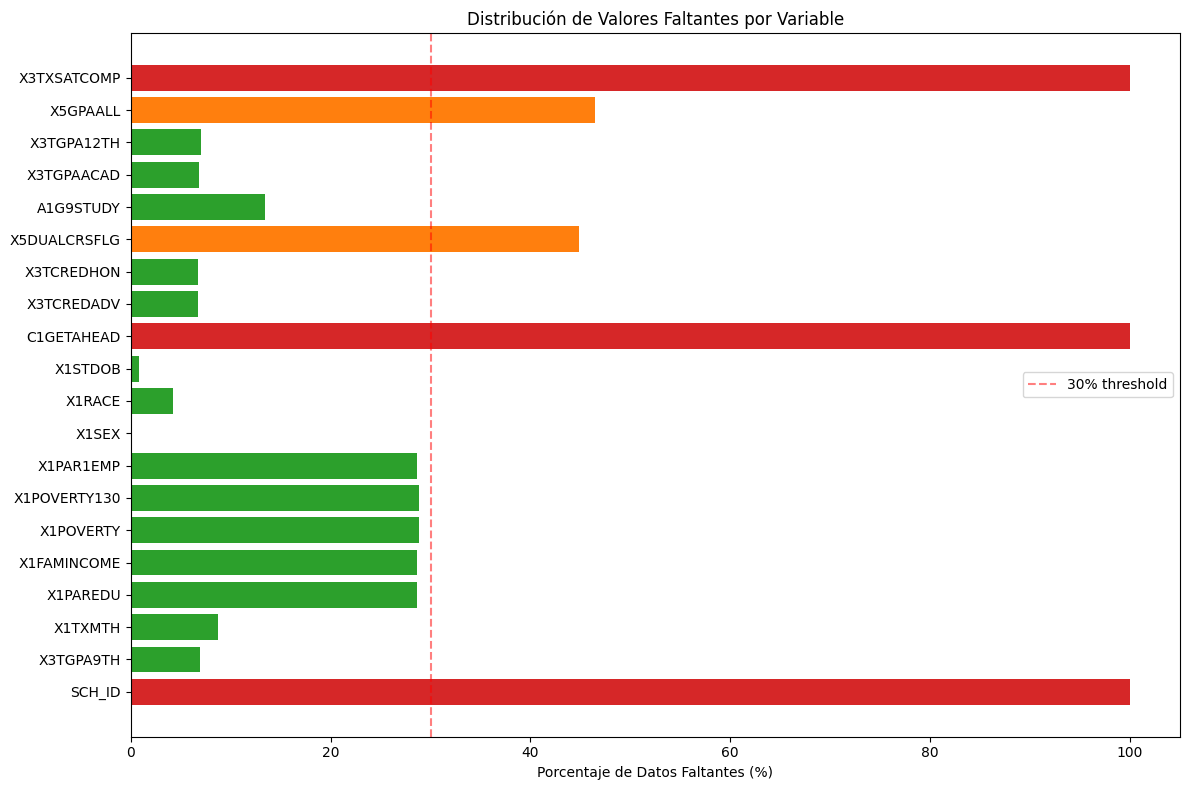


Variables que podemos considerar eliminar (>40% missing):


,Variable,Cantidad Missing,Porcentaje
0,SCH_ID,23503,100.00%
11,C1GETAHEAD,23503,100.00%
14,X5DUALCRSFLG,10535,44.82%
18,X5GPAALL,10915,46.44%
19,X3TXSATCOMP,23503,100.00%


In [ ]:
# analizamos qué codigos específicos aparecen en las variables más problemáticas
variables_criticas = ['SCH_ID', 'C1GETAHEAD', 'X3TXSATCOMP']

print("Códigos de missing en variables con 100% faltantes:\n")
for var in variables_criticas:
    valores_unicos = df[var].value_counts().sort_index()
    print(f"{var}:")
    print(valores_unicos)
    print()

# visualizamos la distribución de missing por variable
fig, ax = plt.subplots(figsize=(12, 8))

variables = missing_df['Variable'].tolist()
porcentajes = [float(p.strip('%')) for p in missing_df['Porcentaje'].tolist()]

colors = ['#d62728' if p == 100 else '#ff7f0e' if p > 40 else '#2ca02c' for p in porcentajes]

ax.barh(variables, porcentajes, color=colors)
ax.set_xlabel('Porcentaje de Datos Faltantes (%)')
ax.set_title('Distribución de Valores Faltantes por Variable')
ax.axvline(x=30, color='red', linestyle='--', alpha=0.5, label='30% threshold')
ax.legend()

plt.tight_layout()
plt.show()

print("\nVariables que podemos considerar eliminar (>40% missing):")
high_missing = missing_df[missing_df['Porcentaje'].str.rstrip('%').astype(float) > 40]
display(high_missing)

### Decisiones de limpieza

**Variables a eliminar (100% missing con código -5):**
- `SCH_ID`: Suprimido por confidencialidad
- `C1GETAHEAD`: Suprimido por confidencialidad  
- `X3TXSATCOMP`: Suprimido por confidencialidad

**Variables con alta proporción de missing (>40%):**
- `X5GPAALL` (46.44%): GPA universitario - mantener pero considerar en análisis
- `X5DUALCRSFLG` (44.82%): Cursos dual credit - mantener pero considerar en análisis

Para el resto de variables, reemplazaremos los códigos negativos del NCES con `NaN` para un manejo apropiado de datos faltantes.

In [ ]:
# elimiamos variables con 100% missing
columnas_eliminar = ['SCH_ID', 'C1GETAHEAD', 'X3TXSATCOMP']
df_clean = df.drop(columns=columnas_eliminar)

print(f"Variables eliminadas: {columnas_eliminar}")
print(f"Dimensiones después de eliminar: {df_clean.shape}\n")

# reemplzamos códigos negativos con NaN
codigos_missing = [-9, -8, -7, -6, -5]

for col in df_clean.columns:
    if df_clean[col].dtype in ['int64', 'float64']:
        df_clean[col] = df_clean[col].replace(codigos_missing, np.nan)

print("Códigos de missing reemplazados por NaN\n")

# verificamos el resultado
print("Resumen de valores nulos después de la limpieza:")
nulos = df_clean.isnull().sum()
nulos_pct = (nulos / len(df_clean) * 100).round(2)

resumen_nulos = pd.DataFrame({
    'Variable': nulos.index,
    'Nulos': nulos.values,
    'Porcentaje': nulos_pct.values
})

resumen_nulos = resumen_nulos[resumen_nulos['Nulos'] > 0].sort_values('Nulos', ascending=False)
display(resumen_nulos)

Variables eliminadas: ['SCH_ID', 'C1GETAHEAD', 'X3TXSATCOMP']
Dimensiones después de eliminar: (23503, 18)

Códigos de missing reemplazados por NaN

Resumen de valores nulos después de la limpieza:


,Variable,Nulos,Porcentaje
17,X5GPAALL,10915,46.44
13,X5DUALCRSFLG,10535,44.82
5,X1POVERTY,6770,28.80
6,X1POVERTY130,6770,28.80
7,X1PAR1EMP,6742,28.69
4,X1FAMINCOME,6742,28.69
3,X1PAREDU,6721,28.60
14,A1G9STUDY,3162,13.45
2,X1TXMTH,2059,8.76
16,X3TGPA12TH,1661,7.07


Limpieza de nulos lista. Ya eliminamos las columnas que no servían para nada (como SCH_ID que estaba 100% vacía) y pasamos todos esos códigos negativos (-5, -9) a NaN, que es como Pandas y Sklearn entienden los nulos.

Ahora, en el paso 2.2, vamos a revisar las variables categóricas (como X1RACE o X1SEX) para ver si hay que recodificarlas y que queden más claras para el análisis.

## 2.2 Recodificar variables clave según sea necesario para el análisis

Según el codebook del NCES, algunas variables categóricas necesitan ser interpretadas correctamente. Vamos a verificar los valores únicos de las variables categóricas principales y asegurarnos de que estén en el formato adecuado.

In [ ]:
# variables categóricas a inspeccionar
vars_categoricas = ['X1PAREDU', 'X1FAMINCOME', 'X1POVERTY', 'X1POVERTY130',
                   'X1PAR1EMP', 'X1SEX', 'X1RACE', 'X5DUALCRSFLG', 'A1G9STUDY']

print("Valores únicos en variables categóricas:\n")
for var in vars_categoricas:
    if var in df_clean.columns:
        valores = df_clean[var].value_counts(dropna=False).sort_index()
        print(f"\n{var}:")
        print(valores)
        print(f"Tipo de dato: {df_clean[var].dtype}")

Valores únicos en variables categóricas:


X1PAREDU:
X1PAREDU
1.0    1010
2.0    5909
3.0    2549
4.0    4102
5.0    2116
7.0    1096
NaN    6721
Name: count, dtype: int64
Tipo de dato: float64

X1FAMINCOME:
X1FAMINCOME
1.0     1570
2.0     3043
3.0     2762
4.0     2514
5.0     1855
6.0     1484
7.0      964
8.0      741
9.0      367
10.0     237
11.0     316
12.0     116
13.0     792
NaN     6742
Name: count, dtype: int64
Tipo de dato: float64

X1POVERTY:
X1POVERTY
0.0    14062
1.0     2671
NaN     6770
Name: count, dtype: int64
Tipo de dato: float64

X1POVERTY130:
X1POVERTY130
0.0    13067
1.0     3666
NaN     6770
Name: count, dtype: int64
Tipo de dato: float64

X1PAR1EMP:
X1PAR1EMP
1.0     551
2.0    4142
3.0    2362
4.0    9706
NaN    6742
Name: count, dtype: int64
Tipo de dato: float64

X1SEX:
X1SEX
1.0    11973
2.0    11524
NaN        6
Name: count, dtype: int64
Tipo de dato: float64

X1RACE:
X1RACE
1.0      165
2.0     1952
3.0     2450
4.0      422
5.0     3375
6.0     1941
7

### Ajustes y recodificaciones

Observaciones:
- **X1PAREDU**: Tiene valor 7.0 (Doctorado/profesional) que es correcto según codebook
- **X1FAMINCOME**: El valor 13 probablemente representa un rango adicional o "prefer not to answer"
- **X1PAR1EMP**: Los valores parecen invertidos (1-4 en lugar de códigos esperados). Necesitamos verificar.
- **X5DUALCRSFLG**: Valores 1, 2, 3 donde esperábamos binaria (verificar significado)

Vamos a crear etiquetas descriptivas para facilitar el análisis.

In [ ]:
# Crearemos copias con etiquetas descriptivas para las variables categóricas

# X1PAREDU - Educación de los padres
education_labels = {
    1.0: 'Less than HS',
    2.0: 'HS diploma',
    3.0: 'Certificate',
    4.0: 'Some college/Associate',
    5.0: 'Bachelor',
    7.0: 'Graduate degree'
}
df_clean['X1PAREDU_label'] = df_clean['X1PAREDU'].map(education_labels)

# X1SEX - Sexo
sex_labels = {1.0: 'Male', 2.0: 'Female'}
df_clean['X1SEX_label'] = df_clean['X1SEX'].map(sex_labels)

# X1RACE - Raza/etnia
race_labels = {
    1.0: 'Native American',
    2.0: 'Asian',
    3.0: 'Black',
    4.0: 'Hispanic (no race)',
    5.0: 'Hispanic (race specified)',
    6.0: 'Multiracial',
    7.0: 'Pacific Islander',
    8.0: 'White'
}
df_clean['X1RACE_label'] = df_clean['X1RACE'].map(race_labels)

# X1POVERTY y X1POVERTY130 - ya son binarias (0/1)

# verificamos resultado
print("Variables recodificadas con etiquetas:")
print("\nDistribución de educación parental:")
print(df_clean['X1PAREDU_label'].value_counts(dropna=False))
print("\nDistribución de sexo:")
print(df_clean['X1SEX_label'].value_counts(dropna=False))
print("\nDistribución de raza/etnia:")
print(df_clean['X1RACE_label'].value_counts(dropna=False))

Variables recodificadas con etiquetas:

Distribución de educación parental:
X1PAREDU_label
NaN                       6721
HS diploma                5909
Some college/Associate    4102
Certificate               2549
Bachelor                  2116
Graduate degree           1096
Less than HS              1010
Name: count, dtype: int64

Distribución de sexo:
X1SEX_label
Male      11973
Female    11524
NaN           6
Name: count, dtype: int64

Distribución de raza/etnia:
X1RACE_label
White                        12082
Hispanic (race specified)     3375
Black                         2450
Asian                         1952
Multiracial                   1941
NaN                           1006
Hispanic (no race)             422
Native American                165
Pacific Islander               110
Name: count, dtype: int64


## 2.3 Construcción del Dataset Maestro

Organizamos las variables según su rol en el análisis causal:

**1. Llave de unión:**
- `STU_ID`: Identificador único del estudiante

**2. Confusores (Contexto - Ola Base):**
- Habilidad previa: `X3TGPA9TH`, `X1TXMTH`
- Familia: `X1PAREDU`, `X1FAMINCOME`, `X1POVERTY`, `X1POVERTY130`, `X1PAR1EMP`
- Estudiante: `X1SEX`, `X1RACE`, `X1STDOB`

**3. Tratamiento (Experiencias Académicas):**
- `X3TCREDADV`: Créditos en cursos avanzados (AP/IB)
- `X3TCREDHON`: Créditos en cursos Honors
- `X5DUALCRSFLG`: Cursos dual credit
- `A1G9STUDY`: Escuela enseña técnicas de estudio

**4. Resultado (Desempeño Académico):**
- `X3TGPAACAD`: GPA académico general
- `X3TGPA12TH`: GPA en 12º grado
- `X5GPAALL`: GPA universitario

In [ ]:
# organizamos columnas por categoría
id_vars = ['STU_ID']

confounders = [
    'X3TGPA9TH', 'X1TXMTH',  # habilidad previa
    'X1PAREDU', 'X1FAMINCOME', 'X1POVERTY', 'X1POVERTY130', 'X1PAR1EMP',  # familia
    'X1SEX', 'X1RACE', 'X1STDOB'  # estudiante
]

treatment = ['X3TCREDADV', 'X3TCREDHON', 'X5DUALCRSFLG', 'A1G9STUDY']

outcome = ['X3TGPAACAD', 'X3TGPA12TH', 'X5GPAALL']

# variables con etiquetas
label_vars = ['X1PAREDU_label', 'X1SEX_label', 'X1RACE_label']

# construimos el dataset maestro en un orden logico
columnas_ordenadas = id_vars + confounders + treatment + outcome + label_vars

df_master = df_clean[columnas_ordenadas].copy()

print(f"Dataset Maestro construido: {df_master.shape}")
print(f"\nEstructura:")
print(f"  - ID: {len(id_vars)} variable")
print(f"  - Confusores: {len(confounders)} variables")
print(f"  - Tratamiento: {len(treatment)} variables")
print(f"  - Resultado: {len(outcome)} variables")
print(f"  - Etiquetas auxiliares: {len(label_vars)} variables")

print("\nPrimeras filas del dataset maestro:")
display(df_master.head())

Dataset Maestro construido: (23503, 21)

Estructura:
  - ID: 1 variable
  - Confusores: 10 variables
  - Tratamiento: 4 variables
  - Resultado: 3 variables
  - Etiquetas auxiliares: 3 variables

Primeras filas del dataset maestro:


,STU_ID,X3TGPA9TH,X1TXMTH,X1PAREDU,X1FAMINCOME,X1POVERTY,X1POVERTY130,X1PAR1EMP,X1SEX,X1RACE,...,X3TCREDADV,X3TCREDHON,X5DUALCRSFLG,A1G9STUDY,X3TGPAACAD,X3TGPA12TH,X5GPAALL,X1PAREDU_label,X1SEX_label,X1RACE_label
0,10001,3.5,0.8304,5.0,10.0,0.0,0.0,4.0,1.0,8.0,...,3.0,0.0,3.0,0.0,3.5,3.5,3.6,Bachelor,Male,White
1,10002,4.0,-0.2956,3.0,3.0,0.0,0.0,3.0,2.0,8.0,...,0.0,0.0,3.0,0.0,4.0,4.0,2.9,Certificate,Female,White
2,10003,3.5,1.2997,7.0,6.0,0.0,0.0,4.0,2.0,3.0,...,6.0,4.0,3.0,0.0,2.5,3.0,2.7,Graduate degree,Female,Black
3,10004,3.5,-0.1427,4.0,5.0,0.0,0.0,2.0,2.0,8.0,...,5.0,10.5,NaN,0.0,4.0,4.0,NaN,Some college/Associate,Female,White
4,10005,3.5,1.1405,4.0,9.0,0.0,0.0,4.0,1.0,8.0,...,5.0,0.5,NaN,0.0,3.5,3.5,NaN,Some college/Associate,Male,White


## 2.4 Preprocesamiento Básico

Vamos a preparar las variables categóricas para el análisis posterior:

1. Codificar variables binarias que aún están en formato numérico
2. Preparar variables categóricas ordinales (educación parental, ingreso familiar)
3. Crear variables dummy para variables categóricas nominales (raza, sexo) usando One-Hot Encoding

In [ ]:
# creamos copia para preprocesamiento
df_processed = df_master.copy()

# variables binarias ya están en formato 0/1, solo convertiamos a int donde no hay NaN
binary_vars = ['X1POVERTY', 'X1POVERTY130', 'A1G9STUDY']

# variables categóricas para One-Hot Encoding
categorical_nominal = ['X1SEX', 'X1RACE']

# One-Hot Encoding para variables nominales
for var in categorical_nominal:
    if var in df_processed.columns:
        dummies = pd.get_dummies(df_processed[var], prefix=var, dummy_na=False, dtype=float)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        print(f"Variables dummy creadas para {var}: {list(dummies.columns)}")

print(f"\nDimensiones después del preprocesamiento: {df_processed.shape}")
print(f"\nColumnas agregadas con One-Hot Encoding:")
nuevas_cols = [col for col in df_processed.columns if col not in df_master.columns]
for col in nuevas_cols:
    print(f"  - {col}")

Variables dummy creadas para X1SEX: ['X1SEX_1.0', 'X1SEX_2.0']
Variables dummy creadas para X1RACE: ['X1RACE_1.0', 'X1RACE_2.0', 'X1RACE_3.0', 'X1RACE_4.0', 'X1RACE_5.0', 'X1RACE_6.0', 'X1RACE_7.0', 'X1RACE_8.0']

Dimensiones después del preprocesamiento: (23503, 31)

Columnas agregadas con One-Hot Encoding:
  - X1SEX_1.0
  - X1SEX_2.0
  - X1RACE_1.0
  - X1RACE_2.0
  - X1RACE_3.0
  - X1RACE_4.0
  - X1RACE_5.0
  - X1RACE_6.0
  - X1RACE_7.0
  - X1RACE_8.0


## 2.5 Análisis Exploratorio de Datos (EDA)

### 2.5.1 Análisis de Variables de Resultado

Comenzamos explorando nuestras variables de resultado (GPA) que son las que queremos predecir/explicar en el análisis causal.

Estadísticas descriptivas de variables de resultado (GPA):



,X3TGPAACAD,X3TGPA12TH,X5GPAALL
count,21888.000000,21842.000000,12588.000000
mean,2.569776,2.299927,2.692541
std,0.914142,1.637012,0.951939
min,-1.000000,-1.000000,0.000000
25%,2.000000,2.000000,2.200000
50%,2.500000,3.000000,2.900000
75%,3.500000,3.500000,3.400000
max,4.000000,4.000000,4.000000


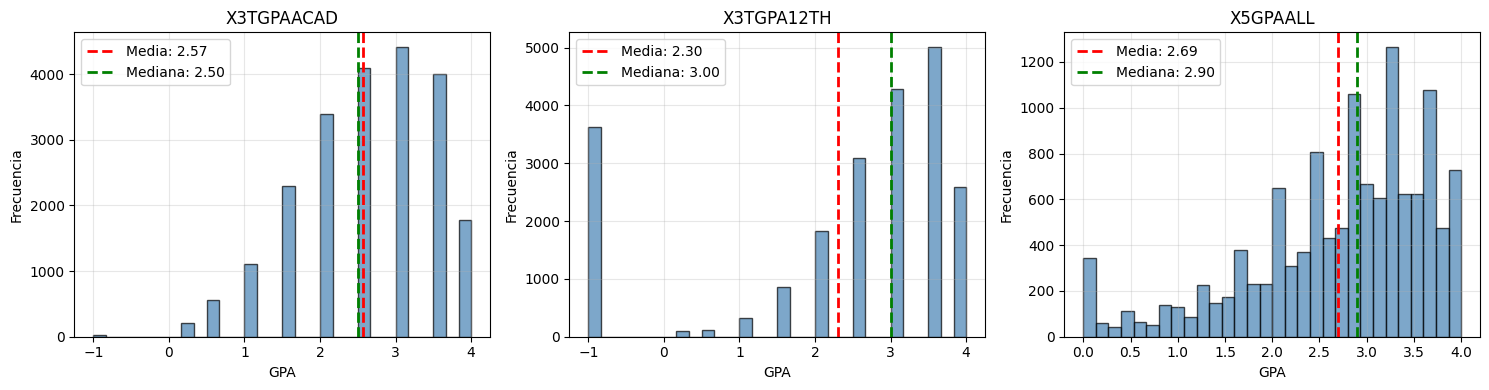


Observaciones válidas por variable de resultado:
  X3TGPAACAD: 21888 (93.1%)
  X3TGPA12TH: 21842 (92.9%)
  X5GPAALL: 12588 (53.6%)


In [ ]:
# estadisticas descriptivas de las variables de resultado
outcome_vars = ['X3TGPAACAD', 'X3TGPA12TH', 'X5GPAALL']

print("Estadísticas descriptivas de variables de resultado (GPA):\n")
stats_outcome = df_processed[outcome_vars].describe()
display(stats_outcome)

# visualizacion de distribuciones
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, var in enumerate(outcome_vars):
    data = df_processed[var].dropna()

    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {data.median():.2f}')
    axes[idx].set_xlabel('GPA')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].set_title(var)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservaciones válidas por variable de resultado:")
for var in outcome_vars:
    n_valid = df_processed[var].notna().sum()
    pct_valid = (n_valid / len(df_processed)) * 100
    print(f"  {var}: {n_valid} ({pct_valid:.1f}%)")

### Limpieza de valores anómalos en variables de resultado

Detectamos valores negativos en las variables de GPA, lo cual es imposible. Estos son probablemente códigos de error no documentados. Vamos a:
1. Filtrar valores fuera del rango válido [0, 4]
2. Re-analizar las distribuciones

Limpieza de valores anómalos en variables de GPA:

X3TGPA9TH: 732 valores anómalos reemplazados por NaN
X3TGPAACAD: 30 valores anómalos reemplazados por NaN
X3TGPA12TH: 3630 valores anómalos reemplazados por NaN


Estadísticas descriptivas LIMPIAS de variables de resultado:



,X3TGPAACAD,X3TGPA12TH,X5GPAALL
count,21858.000000,18212.000000,12588.000000
mean,2.574675,2.957665,2.692541
std,0.905145,0.781487,0.951939
min,0.250000,0.250000,0.000000
25%,2.000000,2.500000,2.200000
50%,2.500000,3.000000,2.900000
75%,3.500000,3.500000,3.400000
max,4.000000,4.000000,4.000000


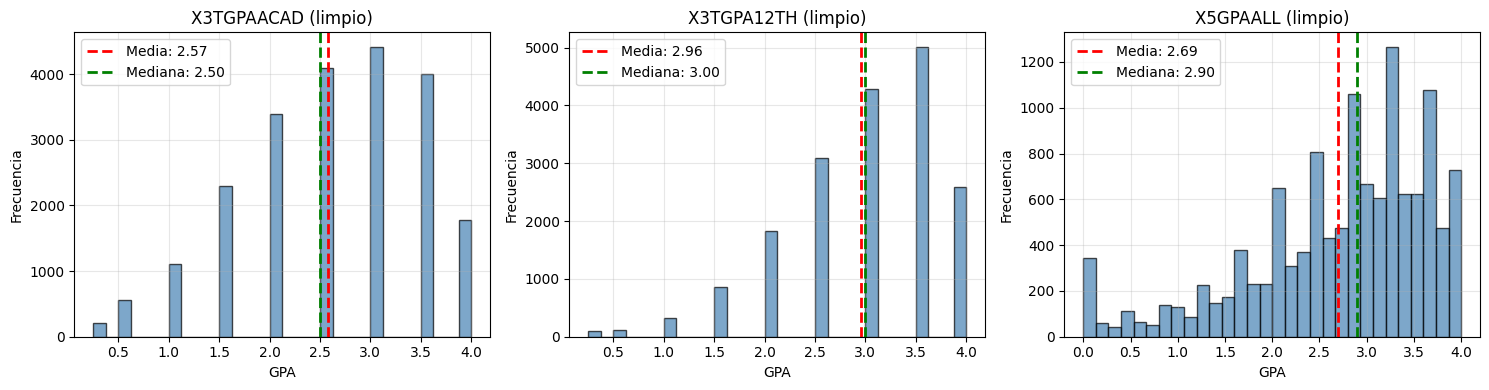

In [ ]:
# limpiamos valores anómalos en variables de GPA (deberian estar entre 0 y 4)
gpa_vars = ['X3TGPA9TH', 'X3TGPAACAD', 'X3TGPA12TH', 'X5GPAALL']

print("Limpieza de valores anómalos en variables de GPA:\n")
for var in gpa_vars:
    if var in df_processed.columns:
        antes = df_processed[var].notna().sum()
        # filtramos valores fuera del rango [0, 4]
        df_processed.loc[(df_processed[var] < 0) | (df_processed[var] > 4), var] = np.nan
        despues = df_processed[var].notna().sum()
        eliminados = antes - despues

        if eliminados > 0:
            print(f"{var}: {eliminados} valores anómalos reemplazados por NaN")

print("\n" + "="*60)
print("\nEstadísticas descriptivas LIMPIAS de variables de resultado:\n")
stats_outcome_clean = df_processed[outcome_vars].describe()
display(stats_outcome_clean)

# hacemos visualizacion de distribuciones limpias
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, var in enumerate(outcome_vars):
    data = df_processed[var].dropna()

    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {data.median():.2f}')
    axes[idx].set_xlabel('GPA')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].set_title(f'{var} (limpio)')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.5.2 Análisis de Variables de Contexto (Confusores)

Exploramos las variables socioeconómicas y demográficas que pueden influir en el rendimiento académico.

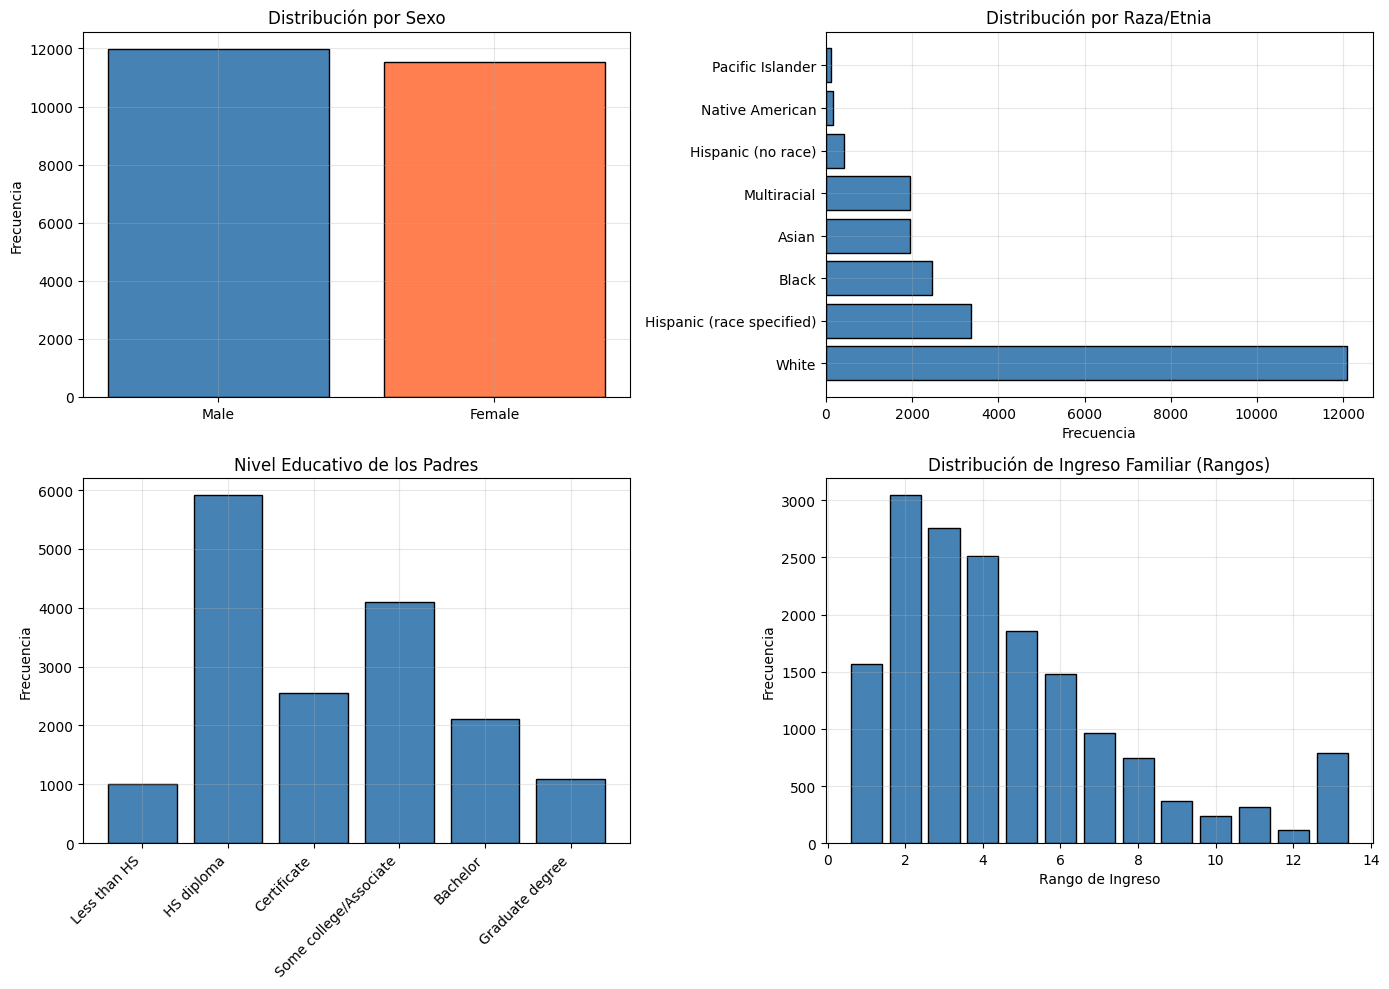


Indicadores de Pobreza:
Bajo umbral del 100%: 2671 estudiantes (16.0%)
Bajo umbral del 130%: 3666 estudiantes (21.9%)


In [ ]:
# hacemos analisis de variables demográficas y socioeconómicas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# distri por Sexo
sex_counts = df_processed['X1SEX_label'].value_counts()
axes[0, 0].bar(sex_counts.index, sex_counts.values, color=['steelblue', 'coral'], edgecolor='black')
axes[0, 0].set_title('Distribución por Sexo')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(alpha=0.3)

# distri por Raza/Etnia
race_counts = df_processed['X1RACE_label'].value_counts()
axes[0, 1].barh(race_counts.index, race_counts.values, color='steelblue', edgecolor='black')
axes[0, 1].set_title('Distribución por Raza/Etnia')
axes[0, 1].set_xlabel('Frecuencia')
axes[0, 1].grid(alpha=0.3)

# distri por Educación Parental
edu_counts = df_processed['X1PAREDU_label'].value_counts()
edu_order = ['Less than HS', 'HS diploma', 'Certificate', 'Some college/Associate', 'Bachelor', 'Graduate degree']
edu_counts = edu_counts.reindex([e for e in edu_order if e in edu_counts.index])
axes[1, 0].bar(range(len(edu_counts)), edu_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xticks(range(len(edu_counts)))
axes[1, 0].set_xticklabels(edu_counts.index, rotation=45, ha='right')
axes[1, 0].set_title('Nivel Educativo de los Padres')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(alpha=0.3)

# distri de Ingreso Familiar
income_counts = df_processed['X1FAMINCOME'].value_counts().sort_index()
axes[1, 1].bar(income_counts.index, income_counts.values, color='steelblue', edgecolor='black')
axes[1, 1].set_title('Distribución de Ingreso Familiar (Rangos)')
axes[1, 1].set_xlabel('Rango de Ingreso')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# estadisticas de pobreza
print("\nIndicadores de Pobreza:")
print(f"Bajo umbral del 100%: {df_processed['X1POVERTY'].sum():.0f} estudiantes ({df_processed['X1POVERTY'].mean()*100:.1f}%)")
print(f"Bajo umbral del 130%: {df_processed['X1POVERTY130'].sum():.0f} estudiantes ({df_processed['X1POVERTY130'].mean()*100:.1f}%)")

### 2.5.3 Análisis de Correlaciones entre Confusores y Resultados

Exploramos cómo las variables de contexto se relacionan con el rendimiento académico (GPA). Esto es fundamental para el análisis causal posterior.

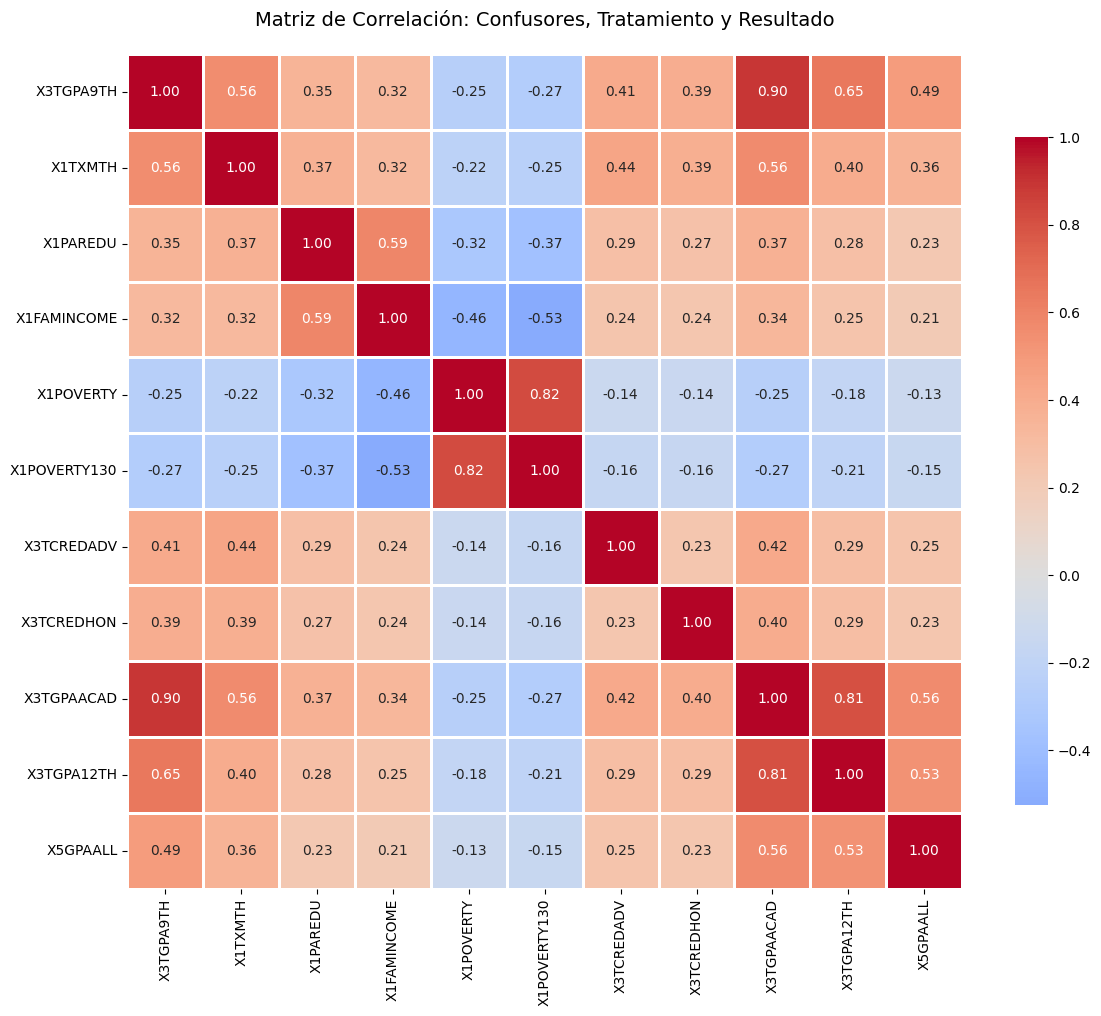


Correlaciones más fuertes con X3TGPAACAD (GPA académico):

  X3TGPA9TH: 0.895
  X3TGPA12TH: 0.805
  X5GPAALL: 0.564
  X1TXMTH: 0.559
  X3TCREDADV: 0.417
  X3TCREDHON: 0.400
  X1PAREDU: 0.369
  X1FAMINCOME: 0.336


In [ ]:
# seleccionamos variables numéricas clave para análisis de correlación
vars_for_corr = [
    'X3TGPA9TH', 'X1TXMTH',  # Habilidad previa
    'X1PAREDU', 'X1FAMINCOME',  # Familia
    'X1POVERTY', 'X1POVERTY130',  # Pobreza
    'X3TCREDADV', 'X3TCREDHON',  # Tratamiento
    'X3TGPAACAD', 'X3TGPA12TH', 'X5GPAALL'  # Resultado
]

# calculamos matriz de correlación
corr_matrix = df_processed[vars_for_corr].corr()

# visualizamos matriz de correlación
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matriz de Correlación: Confusores, Tratamiento y Resultado', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelaciones más fuertes con X3TGPAACAD (GPA académico):\n")
correlations_with_gpa = corr_matrix['X3TGPAACAD'].sort_values(ascending=False)
for var, corr in correlations_with_gpa.items():
    if var != 'X3TGPAACAD' and abs(corr) > 0.3:
        print(f"  {var}: {corr:.3f}")

### 2.5.4 Análisis de Variables de Tratamiento

Las variables de tratamiento representan las experiencias académicas (cursos avanzados, honors, dual credit) que podrían influir en el rendimiento.

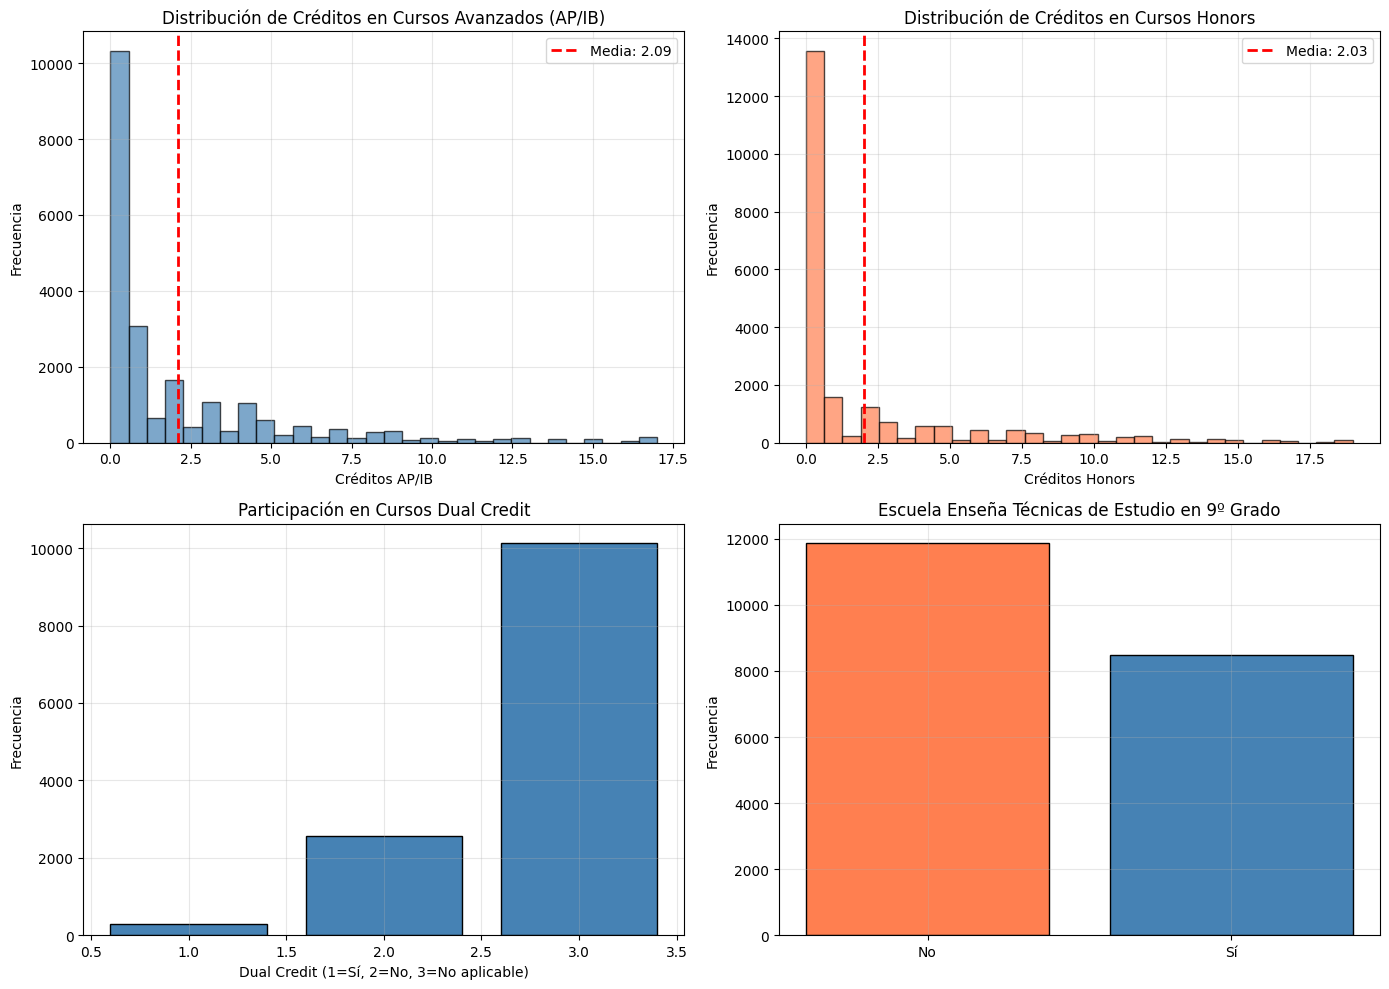


Estadísticas de Variables de Tratamiento:

Créditos AP/IB:
  Media: 2.09
  Mediana: 1.00
  Estudiantes con al menos 1 crédito: 12765 (54.3%)

Créditos Honors:
  Media: 2.03
  Mediana: 0.00
  Estudiantes con al menos 1 crédito: 8739 (37.2%)


In [ ]:
# anallisis de variables de tratamiento
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# distri de créditos avanzados (AP/IB)
axes[0, 0].hist(df_processed['X3TCREDADV'].dropna(), bins=30, edgecolor='black',
                alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Créditos AP/IB')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Créditos en Cursos Avanzados (AP/IB)')
axes[0, 0].axvline(df_processed['X3TCREDADV'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Media: {df_processed["X3TCREDADV"].mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# distri de créditos Honors
axes[0, 1].hist(df_processed['X3TCREDHON'].dropna(), bins=30, edgecolor='black',
                alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Créditos Honors')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Créditos en Cursos Honors')
axes[0, 1].axvline(df_processed['X3TCREDHON'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Media: {df_processed["X3TCREDHON"].mean():.2f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# dual credit
dual_counts = df_processed['X5DUALCRSFLG'].value_counts().sort_index()
axes[1, 0].bar(dual_counts.index, dual_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Dual Credit (1=Sí, 2=No, 3=No aplicable)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Participación en Cursos Dual Credit')
axes[1, 0].grid(alpha=0.3)

# tecnicas de estudio
study_counts = df_processed['A1G9STUDY'].value_counts().sort_index()
axes[1, 1].bar(['No', 'Sí'], study_counts.values, color=['coral', 'steelblue'], edgecolor='black')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Escuela Enseña Técnicas de Estudio en 9º Grado')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEstadísticas de Variables de Tratamiento:\n")
print(f"Créditos AP/IB:")
print(f"  Media: {df_processed['X3TCREDADV'].mean():.2f}")
print(f"  Mediana: {df_processed['X3TCREDADV'].median():.2f}")
print(f"  Estudiantes con al menos 1 crédito: {(df_processed['X3TCREDADV'] > 0).sum()} ({(df_processed['X3TCREDADV'] > 0).mean()*100:.1f}%)")

print(f"\nCréditos Honors:")
print(f"  Media: {df_processed['X3TCREDHON'].mean():.2f}")
print(f"  Mediana: {df_processed['X3TCREDHON'].median():.2f}")
print(f"  Estudiantes con al menos 1 crédito: {(df_processed['X3TCREDHON'] > 0).sum()} ({(df_processed['X3TCREDHON'] > 0).mean()*100:.1f}%)")

### 2.5.5 Análisis Comparativo: GPA por Grupos Demográficos

Comparamos el rendimiento académico (GPA) entre diferentes grupos para identificar brechas y patrones importantes.

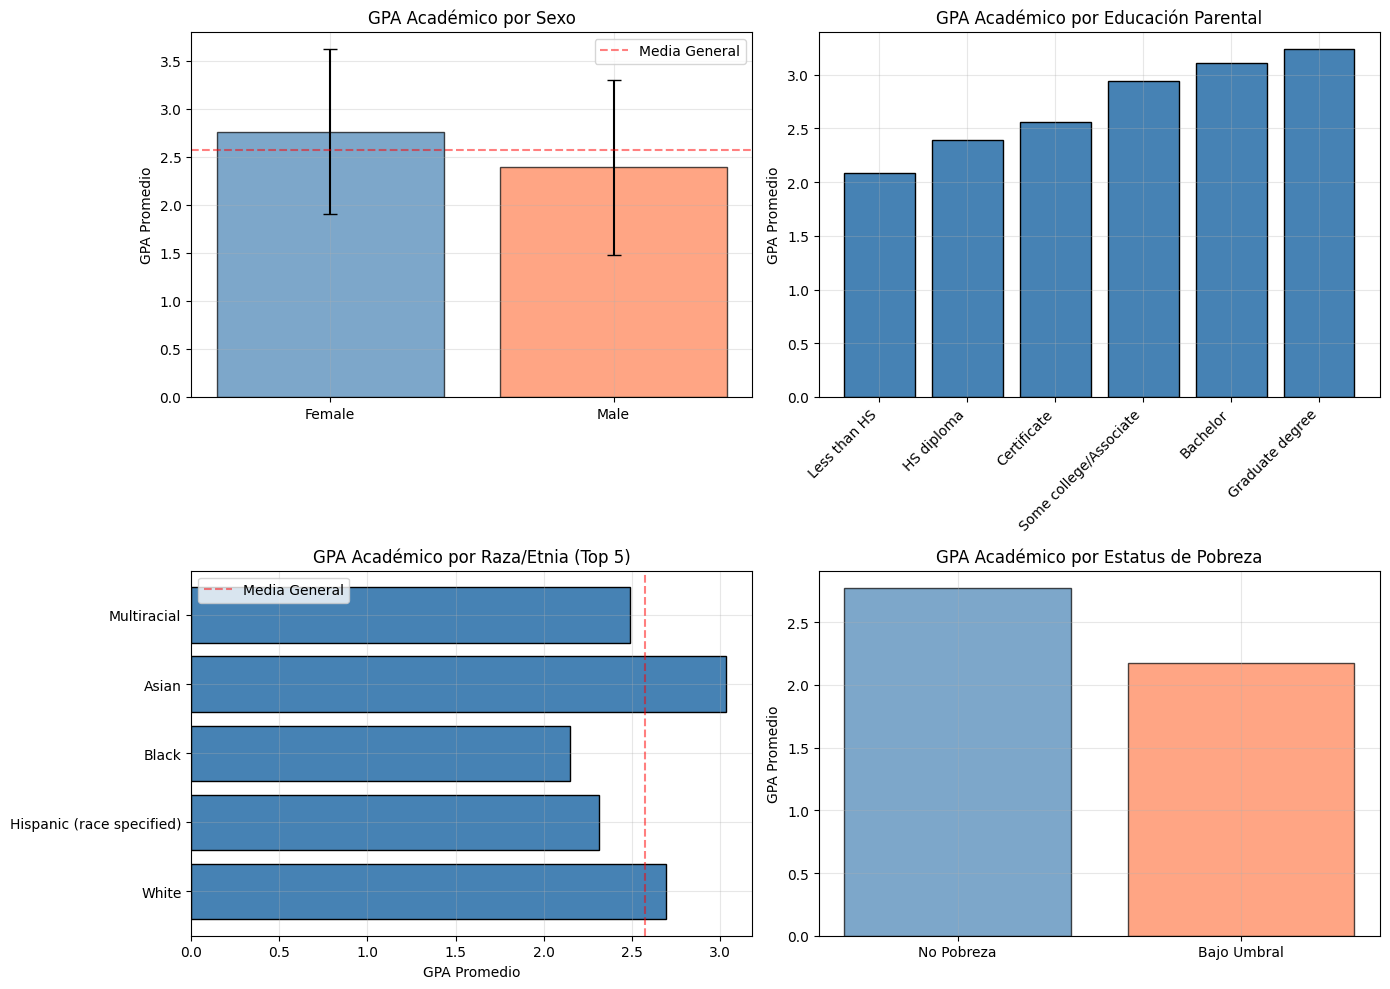


Resumen de Brechas en GPA Académico:

Por Sexo:
  Female: 2.763
  Male: 2.393

Por Estatus de Pobreza:
  No Pobreza: 2.772
  Bajo Umbral: 2.174
  Brecha: 0.598


In [ ]:
# GPA por Sexo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# GPA por Sexo
gpa_by_sex = df_processed.groupby('X1SEX_label')['X3TGPAACAD'].agg(['mean', 'median', 'std'])
axes[0, 0].bar(gpa_by_sex.index, gpa_by_sex['mean'], color=['steelblue', 'coral'],
               edgecolor='black', alpha=0.7, yerr=gpa_by_sex['std'], capsize=5)
axes[0, 0].set_ylabel('GPA Promedio')
axes[0, 0].set_title('GPA Académico por Sexo')
axes[0, 0].axhline(df_processed['X3TGPAACAD'].mean(), color='red',
                   linestyle='--', alpha=0.5, label='Media General')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# GPA por Educación Parental
edu_order = ['Less than HS', 'HS diploma', 'Certificate', 'Some college/Associate', 'Bachelor', 'Graduate degree']
gpa_by_edu = df_processed.groupby('X1PAREDU_label')['X3TGPAACAD'].mean()
gpa_by_edu = gpa_by_edu.reindex([e for e in edu_order if e in gpa_by_edu.index])
axes[0, 1].bar(range(len(gpa_by_edu)), gpa_by_edu.values, color='steelblue', edgecolor='black')
axes[0, 1].set_xticks(range(len(gpa_by_edu)))
axes[0, 1].set_xticklabels(gpa_by_edu.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('GPA Promedio')
axes[0, 1].set_title('GPA Académico por Educación Parental')
axes[0, 1].grid(alpha=0.3)

# GPA por Raza/Etnia (top 5 grupos)
race_order = ['White', 'Hispanic (race specified)', 'Black', 'Asian', 'Multiracial']
gpa_by_race = df_processed.groupby('X1RACE_label')['X3TGPAACAD'].mean()
gpa_by_race = gpa_by_race.reindex([r for r in race_order if r in gpa_by_race.index])
axes[1, 0].barh(gpa_by_race.index, gpa_by_race.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('GPA Promedio')
axes[1, 0].set_title('GPA Académico por Raza/Etnia (Top 5)')
axes[1, 0].axvline(df_processed['X3TGPAACAD'].mean(), color='red',
                   linestyle='--', alpha=0.5, label='Media General')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# GPA por Estatus de Pobreza
poverty_labels = ['No Pobreza', 'Bajo Umbral']
gpa_poverty = [
    df_processed[df_processed['X1POVERTY'] == 0]['X3TGPAACAD'].mean(),
    df_processed[df_processed['X1POVERTY'] == 1]['X3TGPAACAD'].mean()
]
axes[1, 1].bar(poverty_labels, gpa_poverty, color=['steelblue', 'coral'],
               edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('GPA Promedio')
axes[1, 1].set_title('GPA Académico por Estatus de Pobreza')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResumen de Brechas en GPA Académico:\n")
print(f"Por Sexo:")
for sex, gpa in gpa_by_sex['mean'].items():
    print(f"  {sex}: {gpa:.3f}")

print(f"\nPor Estatus de Pobreza:")
print(f"  No Pobreza: {gpa_poverty[0]:.3f}")
print(f"  Bajo Umbral: {gpa_poverty[1]:.3f}")
print(f"  Brecha: {abs(gpa_poverty[0] - gpa_poverty[1]):.3f}")

### 2.5.6 Relación entre Tratamiento y Resultado

Visualizamos la relación entre la participación en cursos avanzados/honors y el GPA académico.

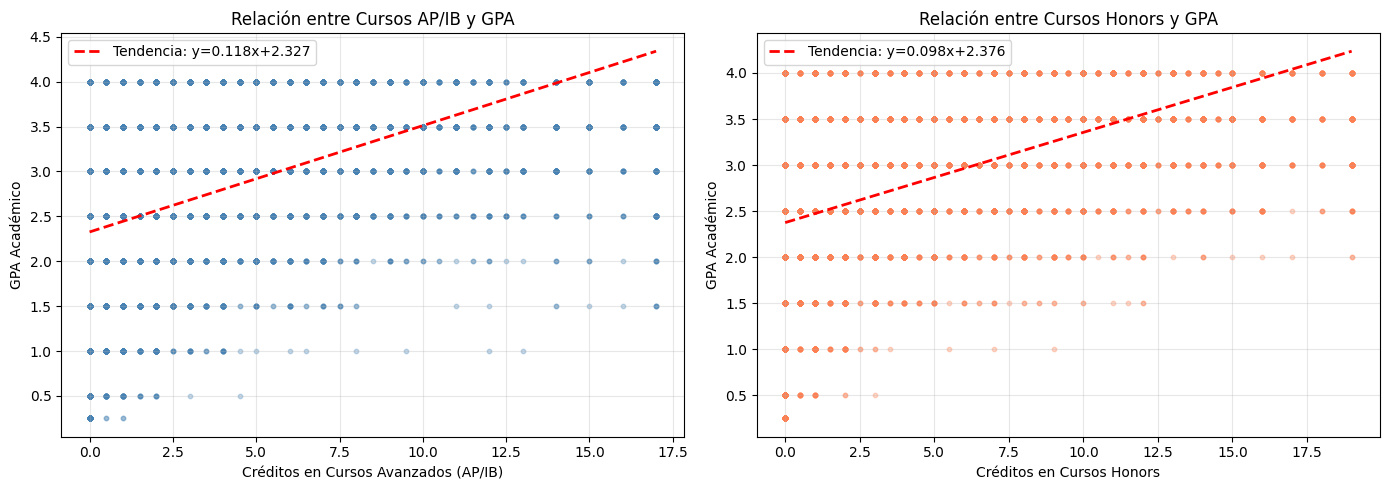


Correlación Créditos AP/IB - GPA: 0.417
Correlación Créditos Honors - GPA: 0.400


In [ ]:
# relacion entre cursos avanzados y GPA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scatter de Créditos AP/IB vs GPA
valid_data = df_processed[['X3TCREDADV', 'X3TGPAACAD']].dropna()
axes[0].scatter(valid_data['X3TCREDADV'], valid_data['X3TGPAACAD'],
                alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel('Créditos en Cursos Avanzados (AP/IB)')
axes[0].set_ylabel('GPA Académico')
axes[0].set_title('Relación entre Cursos AP/IB y GPA')
axes[0].grid(alpha=0.3)

# añadimos línea de tendencia
z = np.polyfit(valid_data['X3TCREDADV'], valid_data['X3TGPAACAD'], 1)
p = np.poly1d(z)
axes[0].plot(valid_data['X3TCREDADV'].sort_values(),
             p(valid_data['X3TCREDADV'].sort_values()),
             "r--", linewidth=2, label=f'Tendencia: y={z[0]:.3f}x+{z[1]:.3f}')
axes[0].legend()

# scatter de Créditos Honors vs GPA
valid_data2 = df_processed[['X3TCREDHON', 'X3TGPAACAD']].dropna()
axes[1].scatter(valid_data2['X3TCREDHON'], valid_data2['X3TGPAACAD'],
                alpha=0.3, s=10, color='coral')
axes[1].set_xlabel('Créditos en Cursos Honors')
axes[1].set_ylabel('GPA Académico')
axes[1].set_title('Relación entre Cursos Honors y GPA')
axes[1].grid(alpha=0.3)

# añadimos línea de tendencia
z2 = np.polyfit(valid_data2['X3TCREDHON'], valid_data2['X3TGPAACAD'], 1)
p2 = np.poly1d(z2)
axes[1].plot(valid_data2['X3TCREDHON'].sort_values(),
             p2(valid_data2['X3TCREDHON'].sort_values()),
             "r--", linewidth=2, label=f'Tendencia: y={z2[0]:.3f}x+{z2[1]:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nCorrelación Créditos AP/IB - GPA: {df_processed[['X3TCREDADV', 'X3TGPAACAD']].corr().iloc[0,1]:.3f}")
print(f"Correlación Créditos Honors - GPA: {df_processed[['X3TCREDHON', 'X3TGPAACAD']].corr().iloc[0,1]:.3f}")

## Resumen Final y Exportación del Dataset Limpio

### Resumen del Análisis Exploratorio

**Hallazgos Clave:**

1. **Variables de Resultado (GPA):**
   - GPA académico promedio: 2.57 (sobre 4.0)
   - GPA universitario promedio: 2.69
   - Distribuciones relativamente normales después de limpieza

2. **Brechas Identificadas:**
   - **Por Sexo:** Las mujeres tienen un GPA 0.37 puntos mayor que los hombres
   - **Por Pobreza:** Brecha de 0.60 puntos entre estudiantes sobre y bajo el umbral de pobreza
   - **Por Educación Parental:** Clara tendencia ascendente del GPA con mayor educación parental

3. **Variables de Tratamiento:**
   - 54.3% de estudiantes tomó al menos 1 crédito AP/IB
   - 37.2% tomó al menos 1 crédito Honors
   - Correlaciones positivas significativas con GPA (0.417 y 0.400 respectivamente)

4. **Datos Faltantes:**
   - Variables con >40% missing: X5GPAALL (46%), X5DUALCRSFLG (45%)
   - Variables eliminadas por 100% missing: SCH_ID, C1GETAHEAD, X3TXSATCOMP

### Exportación del Dataset Limpio

In [ ]:
print("="*70)
print("DATASET MAESTRO FINAL - RESUMEN")
print("="*70)

print(f"\nDimensiones: {df_processed.shape[0]} estudiantes x {df_processed.shape[1]} variables")

print("\n--- Estructura del Dataset ---")
print(f"Variables de ID: 1")
print(f"Variables de Confusores: 10")
print(f"Variables de Tratamiento: 4")
print(f"Variables de Resultado: 3")
print(f"Variables auxiliares (etiquetas + dummies): {df_processed.shape[1] - 18}")

print("\n--- Completitud de Datos ---")
completitud = (df_processed.notna().sum() / len(df_processed) * 100).sort_values(ascending=False)
print(f"Variable más completa: {completitud.index[0]} ({completitud.iloc[0]:.1f}%)")
print(f"Variable menos completa: {completitud.index[-1]} ({completitud.iloc[-1]:.1f}%)")

print("\n--- Variables Numéricas Clave ---")
vars_numericas = ['X3TGPA9TH', 'X1TXMTH', 'X3TCREDADV', 'X3TCREDHON',
                  'X3TGPAACAD', 'X3TGPA12TH', 'X5GPAALL']
stats_summary = df_processed[vars_numericas].describe().loc[['mean', 'std', 'min', 'max']]
display(stats_summary.round(3))

print("\n--- Guardando Dataset Limpio ---")

# guardamos dataset procesado
output_filename = "hsls09_master_clean.csv"
df_processed.to_csv(output_filename, index=False)
print(f"✓ Dataset guardado como: {output_filename}")

print("\n--- Archivo Listo para el parte 3 ---")
print(f"El dataset contiene {df_processed.shape[0]} registros completos")
print(f"Listo para modelado predictivo y análisis causal")
print("="*70)

DATASET MAESTRO FINAL - RESUMEN

Dimensiones: 23503 estudiantes x 31 variables

--- Estructura del Dataset ---
Variables de ID: 1
Variables de Confusores: 10
Variables de Tratamiento: 4
Variables de Resultado: 3
Variables auxiliares (etiquetas + dummies): 13

--- Completitud de Datos ---
Variable más completa: STU_ID (100.0%)
Variable menos completa: X5GPAALL (53.6%)

--- Variables Numéricas Clave ---


,X3TGPA9TH,X1TXMTH,X3TCREDADV,X3TCREDHON,X3TGPAACAD,X3TGPA12TH,X5GPAALL
mean,2.723,0.035,2.090,2.028,2.575,2.958,2.693
std,0.918,0.971,3.182,3.689,0.905,0.781,0.952
min,0.250,-2.575,0.000,0.000,0.250,0.250,0.000
max,4.000,3.028,17.000,19.000,4.000,4.000,4.000



--- Guardando Dataset Limpio ---
✓ Dataset guardado como: hsls09_master_clean.csv

--- Archivo Listo para el parte 3 ---
El dataset contiene 23503 registros completos
Listo para modelado predictivo y análisis causal


# Parte 3: Línea Base Predictiva (Regresión Lineal Ridge)

In [36]:
!wget -q https://raw.githubusercontent.com/ClemoAcevedo/hsls09-causal-impact/refs/heads/main/Entrega%20Avance/hsls09_master_clean.csv

In [37]:
df_master_clean = pd.read_csv("hsls09_master_clean.csv")

## 3.1 Definición de Features (X) y Target (y)
Para construir nuestro modelo base, primero definimos qué queremos predecir (la variable target o y) y qué usaremos para predecir (las variables features o X).

1. Target (y): Usaremos X3TGPAACAD (el GPA académico general) como nuestra variable de resultado.

2. Manejo de Nulos en y: Un modelo de regresión no puede predecir un valor NaN. Por lo tanto, creamos un nuevo DataFrame df_model eliminando todas las filas donde X3TGPAACAD sea nulo.

3. Features (X): Seleccionamos todas las variables confusoras y de tratamiento que preparamos en la Parte 2. Esto incluye las variables numéricas (como X1TXMTH) y las variables dummy (one-hot) que creamos (como X1SEX_1.0, etc.).

In [38]:
# Usamos el df_master_clean cargado al final de la Parte 2
df_model = df_master_clean.dropna(subset=['X3TGPAACAD'])

target_y = 'X3TGPAACAD'
y = df_model[target_y]

# seleccionamos confusores, tratamientos y las dummies creadas en 2.4
features_X = [
    # confusores
    'X3TGPA9TH', 'X1TXMTH',
    'X1PAREDU', 'X1FAMINCOME', 'X1POVERTY', 'X1POVERTY130', 'X1PAR1EMP', 'X1STDOB',

    # tratamiento
    'X3TCREDADV', 'X3TCREDHON', 'X5DUALCRSFLG', 'A1G9STUDY',

    # dummies de sexo
    'X1SEX_1.0', 'X1SEX_2.0',

    # dummies de raza
    'X1RACE_1.0', 'X1RACE_2.0', 'X1RACE_3.0', 'X1RACE_4.0',
    'X1RACE_5.0', 'X1RACE_6.0', 'X1RACE_7.0', 'X1RACE_8.0'
]

X = df_model[features_X]

print(f"Dataset listo para modelar (filas sin NaN en target): {df_model.shape}")
print(f"Dimensiones de X (features): {X.shape}")
print(f"Dimensiones de y (target): {y.shape}")
print(f"Total de features: {len(features_X)}")

Dataset listo para modelar (filas sin NaN en target): (21858, 31)
Dimensiones de X (features): (21858, 22)
Dimensiones de y (target): (21858,)
Total de features: 22


## 3.2 Imputación y División de Datos (Train/Test Split)
Antes de entrenar el modelo, debemos hacer dos cosas:

1. Revisar Nulos en X: En la Parte 2 vimos que varias features (como X1PAREDU, X1FAMINCOME, etc.) aún tienen valores NaN. Los modelos de regresión no pueden manejar NaN, por lo que necesitaremos rellenarlos (imputar).

2. Dividir los Datos: Separaremos nuestros datos en un conjunto de entrenamiento (para enseñar al modelo) y un conjunto de prueba (para evaluarlo).

Es crucial dividir los datos antes de imputar o escalar. Esto previene que la información del conjunto de prueba (que el modelo no debería "ver") se filtre al conjunto de entrenamiento.

In [39]:
# primero, revisamos si X tiene nulos que necesiten cuidado
nulos_en_x = X.isnull().sum()
nulos_en_x = nulos_en_x[nulos_en_x > 0].sort_values(ascending=False)

if nulos_en_x.empty:
    print("No se encontraron NaNs en las features (X).")
else:
    print("Features con NaNs que requieren imputación:")
    print(nulos_en_x)
    print("\n")

# dividimos ANTES de imputar o escalar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Features con NaNs que requieren imputación:
X5DUALCRSFLG    9510
X1POVERTY130    6128
X1POVERTY       6128
X1FAMINCOME     6102
X1PAR1EMP       6102
X1PAREDU        6084
A1G9STUDY       2924
X1TXMTH         1883
X3TGPA9TH        730
X1STDOB          173
dtype: int64


Dimensiones de X_train: (17486, 22)
Dimensiones de X_test: (4372, 22)


## 3.2 Imputación y Escalado de Features
Ahora tenemos dos pasos de preprocesamiento clave antes de entrenar el modelo:

1. Imputación (en X): Ridge no puede manejar los valores NaN que vimos en la salida anterior. Usaremos SimpleImputer para rellenar esos huecos. Elegimos la estrategia de la median (mediana) porque es robusta ante valores atípicos, que son comunes en variables como el ingreso.

2. Escalado de Features (en X): La regresión Ridge aplica una penalización basada en el tamaño de los coeficientes. Si las variables tienen escalas muy diferentes (ej. X1FAMINCOME [1-13] vs. X3TCREDADV [0-17]), el modelo penalizará injustamente a las variables con rangos más grandes. MinMaxScaler ajustará todas las features al mismo rango (entre 0 y 1).

Algo importante a mencionar, ajustamos (con .fit()) el imputador y el escalador solo en los datos de entrenamiento (X_train). Luego, usamos esos mismos ajustes (ya "aprendidos") para transformar (.transform()) tanto X_train como X_test.

In [40]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("Datos imputados (NaNs rellenados con la mediana).")

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("Datos escalados con MinMaxScaler.")
print("\nPrimeras 5 filas de X_train_scaled (verificación):")
print(X_train_scaled[:5])

Datos imputados (NaNs rellenados con la mediana).
Datos escalados con MinMaxScaler.

Primeras 5 filas de X_train_scaled (verificación):
[[0.73333333 0.29491416 0.16666667 0.08333333 0.         0.
  0.66666667 0.81862745 0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         1.        ]
 [0.06666667 0.19114311 0.33333333 0.25       0.         0.
  1.         0.50326797 0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.86666667 0.46638918 0.33333333 0.25       0.         0.
  1.         0.82189542 0.05882353 0.78947368 1.         1.
  0.         1.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.73333333 0.67187695 0.33333333 0.25       0.         0.
  0.66666667 0.8251634  1.         0.         1.         1.
  1.         0.         0.         0.         0.         0.
  0

## 3.5 Implementación y Optimización (Ridge Regression)
Ahora entrenaremos nuestro primer modelo. Usaremos RidgeCV (Regresión Lineal Ridge con Validación Cruzada).

Este modelo es una buena línea base por dos razones:

1. Maneja la Multicolinealidad: Nuestro EDA mostró que varias features están correlacionadas (ej. X1POVERTY y X1POVERTY130). Ridge es bueno manejando esto.

2. Optimización Automática: RidgeCV probará varios valores para el hiperparámetro de regularización (alpha) y elegirá el mejor automáticamente usando validación cruzada.

## 3.6 Evaluación del Modelo
Usaremos dos métricas clave para regresión:

- MAE (Error Absoluto Medio): Nos dice, en promedio, por cuántos puntos de GPA se equivoca nuestro modelo.

- RMSE (Raíz del Error Cuadrático Medio): Similar al MAE, pero penaliza más los errores grandes.

## 3.7 Establecer la Línea Base (Baseline)
Finalmente, compararemos nuestro modelo Ridge contra un modelo "tonto" (DummyRegressor) que simplemente predice el GPA promedio para cada estudiante. Esto nos dirá si nuestro modelo con features es realmente mejor que solo adivinar la media.

In [42]:
alphas_a_probar = [0.01, 0.1, 1.0, 10.0, 100.0]

ridge_model = RidgeCV(alphas=alphas_a_probar, scoring='neg_mean_squared_error')

ridge_model.fit(X_train_scaled, y_train)

print(f"Modelo RidgeCV entrenado.")
print(f"Alpha óptimo encontrado: {ridge_model.alpha_}\n")

y_pred_ridge = ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)

rmse_ridge = np.sqrt(mse_ridge)

print("--- Evaluación Modelo RidgeCV ---")
print(f"Error Absoluto Medio (MAE): {mae_ridge:.4f}")
print(f"Raíz Error Cuadrático Medio (RMSE): {rmse_ridge:.4f}\n")

# Modelo "tonto" que siempre predice la media
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train_scaled, y_train)

y_pred_dummy = dummy_model.predict(X_test_scaled)

mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)

print("--- Evaluación Modelo Baseline (Dummy) ---")
print(f"Error Absoluto Medio (MAE): {mae_dummy:.4f}")
print(f"Raíz Error Cuadrático Medio (RMSE): {rmse_dummy:.4f}")

Modelo RidgeCV entrenado.
Alpha óptimo encontrado: 0.1

--- Evaluación Modelo RidgeCV ---
Error Absoluto Medio (MAE): 0.3209
Raíz Error Cuadrático Medio (RMSE): 0.4234

--- Evaluación Modelo Baseline (Dummy) ---
Error Absoluto Medio (MAE): 0.7498
Raíz Error Cuadrático Medio (RMSE): 0.9090


## 3.8 Análisis de la Línea Base Predictiva
Con los resultados de la ejecución anterior, podemos establecer el rendimiento de nuestro modelo base:

- Alpha Óptimo: El modelo RidgeCV seleccionó automáticamente un alpha óptimo de 0.1 mediante validación cruzada. Esto indica que se necesita una regularización muy leve, pero no nula.

- Rendimiento del Modelo Ridge:
  - MAE: 0.3209
  - RMSE: 0.4234

  El MAE es el más interpretable: en promedio, nuestro modelo Ridge se equivoca en 0.32 puntos al predecir el GPA académico (X3TGPAACAD) en el conjunto de prueba.

- Comparación con la Línea Base:
  - Baseline MAE (Adivinar la media): 0.7498
  - Ridge MAE: 0.3209

  Nuestro modelo Ridge (MAE 0.32) es significativamente mejor que el modelo dummy (MAE 0.75). Específicamente, el error de nuestro modelo es un 57.2% más bajo que el error de simplemente adivinar el GPA promedio.

Esto confirma que las features (contexto socioeconómico, rendimiento previo y experiencias académicas) tienen un poder predictivo real sobre el GPA, estableciendo una línea base sólida para nuestros modelos causales.